<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap01/1_1_BackgroundMathematics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Notebook 1.1 -- Background Mathematics**

The purpose of this Python notebook is to make sure you can use CoLab and to familiarize yourself with some of the background mathematical concepts that you are going to need to understand deep learning. <br><br> It's not meant to be difficult and it may be that you know some or all of this information already.<br><br> Math is *NOT* a spectator sport.  You won't learn it by just listening to lectures or reading books.  It really helps to interact with it and explore yourself. <br><br> Work through the cells below, running each cell in turn.  In various places you will see the words **"TO DO"**. Follow the instructions at these places and write code to complete the functions.  There are also questions interspersed in the text.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [10]:
# import a bunch of mojo things to help with math computation

from benchmark import Unit, run
from math import iota
from math import ceil
from python import Python
from python.object import PythonObject
from runtime.llcl import num_cores
from algorithm import parallelize, vectorize, vectorize_unroll
from tensor import Tensor
from utils.index import Index


# Imports math library
#import numpy as np
# Imports plotting library
#import matplotlib.pyplot as plt

In [2]:
%%python
from importlib.util import find_spec
import shutil
import subprocess

fix = """
-------------------------------------------------------------------------
fix following the steps here:
    https://github.com/modularml/mojo/issues/1085#issuecomment-1771403719
-------------------------------------------------------------------------
"""

def install_if_missing(name: str):
    if find_spec(name):
        return

    print(f"{name} not found, installing...")
    try:
        if shutil.which('python3'): python = "python3"
        elif shutil.which('python'): python = "python"
        else: raise ("python not on path" + fix)
        subprocess.check_call([python, "-m", "pip", "install", name])
    except:
        raise ImportError(f"{name} not found" + fix)

install_if_missing("numpy")
install_if_missing("matplotlib")

**Linear functions**<br> We will be using the term *linear equation* to mean a weighted sum of inputs plus an offset. If there is just one input $x$, then this is a straight line:

\begin{equation}y=\beta+\omega x,\end{equation} <br>

where $\beta$ is the y-intercept of the linear and $\omega$ is the slope of the line. When there are two inputs $x_{1}$ and $x_{2}$, then this becomes:

\begin{equation}y=\beta+\omega_1 x_1 + \omega_2 x_2.\end{equation} <br><br>

Any other functions are by definition **non-linear**.




As far as I can tell, Mojo doesn't include range initialization functions for Tensors. To start this code off, create a tensor factory that returns a linear Tensor initialized as close as possible to [start, end] with the defined step size

In [14]:
fn linear_init[T: DType](start: SIMD[T,1] = 0, end: SIMD[T,1] = 1, step: SIMD[T,1] = 1) -> Tensor[T]:
    from math import ceil
    let length = ceil((end-start)/step).to_int()
    var t = Tensor[T](length)
    var v = start
    for i in range(length):
        t[i] = v
        v = v + step

    return t

fn linear_init_SIMD[T: DType, simd_width: Int](start: SIMD[T,1], end: SIMD[T,1], step: SIMD[T,1]) -> Tensor[T]:
    from math import ceil

    let length = ceil((end-start)/step).to_int()
    var t = Tensor[T](length)
    let range = iota[T, simd_width]()*step

    @parameter
    fn vector_init[s_w: Int](col: Int):
        t.data().simd_store[simd_width](
            col,
            (start + col*step) + range)

    vectorize_unroll[simd_width, 8, vector_init](length)

    return t

alias float_type = DType.float64
alias simd_width = simdwidthof[float_type]()

let x1 = linear_init_SIMD[float_type, simd_width](0, 10, 0.001)
let x2 = linear_init[float_type](0, 10, 0.001)

print(x1 - x2)

fn bench_linear():
    linear_init[float_type](0, 100, 0.001)

fn bench_vector():
    linear_init_SIMD[float_type, simd_width](0, 100, 0.001)

lin = benchmark.run[bench_linear]().mean(Unit.ms)
vec = benchmark.run[bench_vector]().mean(Unit.ms)

print("lin", lin, Unit.ms)
print("vec", vec, Unit.ms)

print(simd_width)

    linear_init[float_type](0, 100, 0.001)
    ~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~
    _ = 

    linear_init_SIMD[float_type, simd_width](0, 100, 0.001)
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~
    _ = 



Tensor([[0.0, 0.0, 0.0, ..., 1.0125233984581428e-13, 1.0125233984581428e-13, 1.0125233984581428e-13]], dtype=float64, shape=10000)
lin 1.5509782516692142e-14 ms
vec 1.6177138815355049e-14 ms
2


In [4]:
# Define a linear function with just one input, x
def linear_function_1D[T: DType](x: Tensor[T], omega: SIMD[T,1], beta: SIMD[T,1]) -> Tensor[T]:
  let y = omega * x + beta

  return y

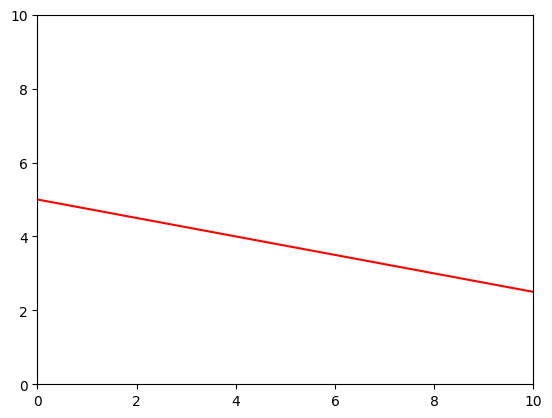

In [5]:
# Plot the 1D linear function

# Define an array of x values from 0 to 10 with increments of 0.01
var x  = linear_init[float_type](0, 10, 0.01)

# Compute y using the function you filled in above
let beta = 5.0
let omega = -0.25

let y = linear_function_1D(x, omega, beta)


def plotit(x: Tensor[float_type], y: Tensor[float_type], l: Int):
    let np = Python.import_module("numpy")
    let plt = Python.import_module("matplotlib.pyplot")
    let colors = Python.import_module("matplotlib.colors")

    numpy_array_x = np.zeros((l), np.float64)
    numpy_array_y = np.zeros((l), np.float64)    

    for i in range(l):
        numpy_array_x.itemset((i), x[i])
        numpy_array_y.itemset((i), y[i])

    let fig_ax = plt.subplots()
    let fig = fig_ax[0]
    fig.set_visible(False)
    let ax = fig_ax[1]
    ax.plot(numpy_array_x,numpy_array_y,'r-')
    ax.set_ylim([0,10])
    ax.set_xlim([0,10])
    ax.set_ylim([0,10])
    ax.set_xlim([0,10])
    fig.set_visible(True)
    plt.show()


plotit(x, y, 1000)

# Plot this function
# fig, ax = plt.subplots()
#ax.plot(x,y,'r-')
#ax.set_ylim([0,10]);ax.set_xlim([0,10])
#ax.set_ylim([0,10]);ax.set_xlim([0,10])
#plt.show

# TODO -- experiment with changing the values of beta and omega
# to understand what they do.  Try to make a line
# that crosses the y-axis at y=10 and the x-axis at x=5

Now let's investigate a 2D linear function

In [41]:
# Code to draw 2D function -- read it so you know what is going on, but you don't have to change it
def draw_2D_function(x1_mesh: Tensor[float_type], x2_mesh: Tensor[float_type], y: Tensor[float_type], l: Int):

    let np = Python.import_module("numpy")
    let plt = Python.import_module("matplotlib.pyplot")
    let colors = Python.import_module("matplotlib.colors")

    numpy_x1 = np.zeros((l), np.float64)
    numpy_x2 = np.zeros((l), np.float64)    
    numpy_y = np.zeros((l, l), np.float64)

    for i in range(l):
        numpy_x1.itemset((i), x1_mesh[i])
        numpy_x2.itemset((i), x2_mesh[i])
        for j in range(l):
            numpy_y.itemset((i,j), y[i,j])

    let fig_ax = plt.subplots()
    let fig = fig_ax[0]
    fig.set_visible(False)
    let ax = fig_ax[1]
    fig.set_size_inches(7,7)

    pos = ax.contourf(numpy_x1, numpy_x2, numpy_y)
    fig.colorbar(pos)
    ax.set_xlabel('x1');ax.set_ylabel('x2')
    levels = np.arange(-10, 10, 1.0)
    ax.contour(numpy_x1, numpy_x2, numpy_y, levels)
    fig.set_visible(True)
    plt.show()


In [51]:
# Define a linear function with two inputs, x1 and x2
def linear_function_2D(x1: Tensor[float_type], x2: Tensor[float_type], beta: Float64, omega1: Float64, omega2: Float64) -> Tensor[float_type]:
    
    let width = x1.shape()[0]
    let height = x2.shape()[0]
    var y = Tensor[float_type](width, height)
    for j in range(height):
        for i in range(width):
            y[Index(i,j)] = x1[i] * omega1 + x2[j] * omega2 + beta

    return y

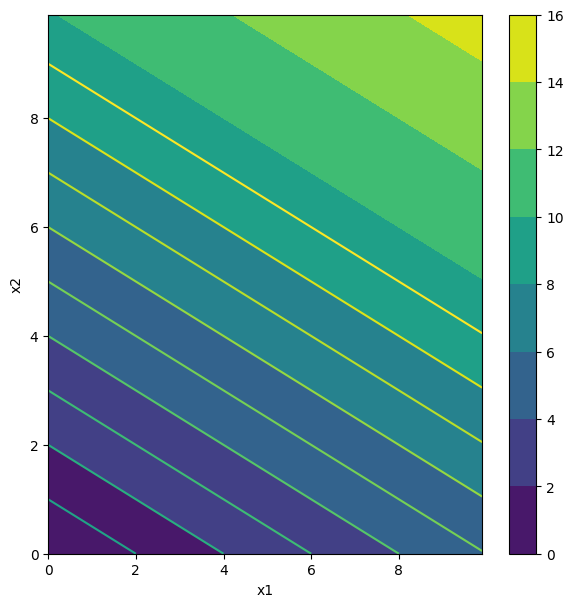

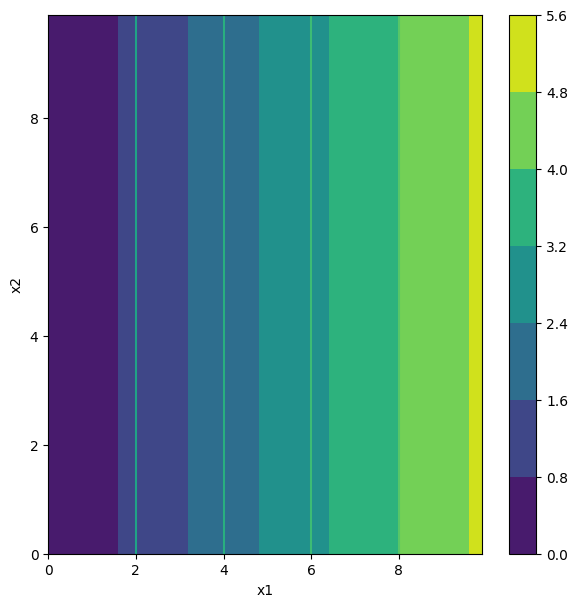

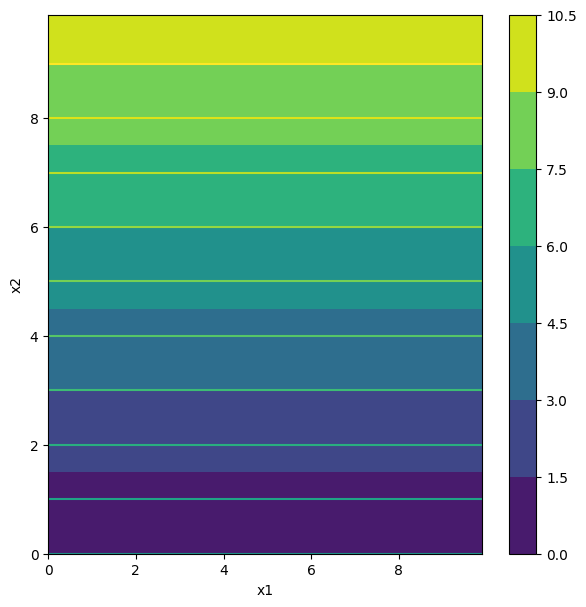

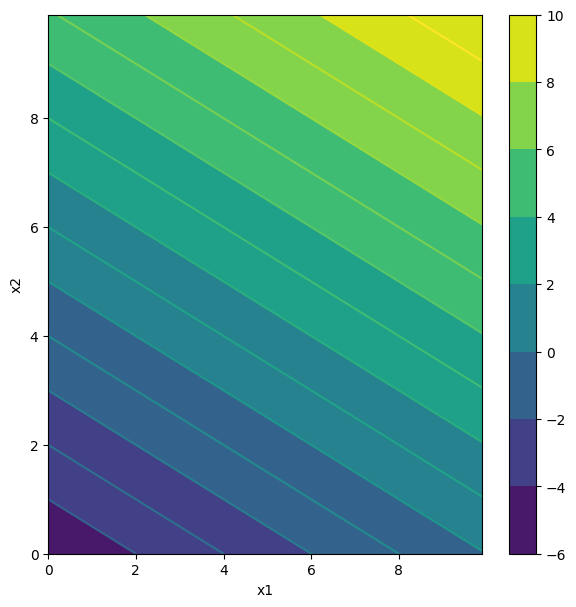

In [57]:
# Plot the 2D function

# Make 2D array of x and y points
x1 = linear_init(0.0, 10.0, 0.1)
x2 = linear_init(0.0, 10.0, 0.1)

y = linear_function_2D(x1, x2, 0.0, 1.0, 0.5)
draw_2D_function(x1,x2,y,100)

# TODO
# Predict what this plot will look like if you set omega_1 to zero
# Change the code and see if you are right.

y = linear_function_2D(x1, x2, 0.0, 0.0, 0.5)
draw_2D_function(x1,x2,y,100)

# TODO
# Predict what this plot will look like if you set omega_2 to zero
# Change the code and see if you are right.

y = linear_function_2D(x1, x2, 0.0, 1.0, 0.0)
draw_2D_function(x1,x2,y,100)

# TODO
# Predict what this plot will look like if you set beta to -5
# Change the code and see if you are correct

y = linear_function_2D(x1, x2, -5.0, 1.0, 0.5)
draw_2D_function(x1,x2,y,100)


Often we will want to compute many linear functions at the same time.  For example, we might have three inputs, $x_1$, $x_2$, and $x_3$ and want to compute two linear functions giving $y_1$ and $y_2$. Of course, we could do this by just running each equation separately,<br><br>

\begin{eqnarray}y_1 &=& \beta_1 + \omega_{11} x_1 + \omega_{12} x_2 + \omega_{13} x_3\\
y_2 &=& \beta_2 + \omega_{21} x_1 + \omega_{22} x_2 + \omega_{23} x_3.
\end{eqnarray}<br>

However, we can write it more compactly with vectors and matrices:

\begin{equation}
\begin{bmatrix} y_1\\ y_2 \end{bmatrix} = \begin{bmatrix}\beta_{1}\\\beta_{2}\end{bmatrix}+ \begin{bmatrix}\omega_{11}&\omega_{12}&\omega_{13}\\\omega_{21}&\omega_{22}&\omega_{23}\end{bmatrix}\begin{bmatrix}x_{1}\\x_{2}\\x_{3}\end{bmatrix},
\end{equation}<br>
or

\begin{equation}
\mathbf{y} = \boldsymbol\beta +\boldsymbol\Omega\mathbf{x}.
\end{equation}

for short.  Here, lowercase bold symbols are used for vectors.  Upper case bold symbols are used for matrices.



In [ ]:
# Define a linear function with three inputs, x1, x2, and x_3
def linear_function_3D(x1,x2,x3,beta,omega1,omega2,omega3):
  # TODO -- replace the code below with formula for a single 3D linear equation
  y = x1

  return y

Let's compute two linear equations, using both the individual equations and the vector / matrix form and check they give the same result

In [ ]:
# Define the parameters
beta1 = 0.5; beta2 = 0.2
omega11 =  -1.0 ; omega12 = 0.4; omega13 = -0.3
omega21 =  0.1  ; omega22 = 0.1; omega23 = 1.2

# Define the inputs
x1 = 4 ; x2 =-1; x3 = 2

# Compute using the individual equations
y1 = linear_function_3D(x1,x2,x3,beta1,omega11,omega12,omega13)
y2 = linear_function_3D(x1,x2,x3,beta2,omega21,omega22,omega23)
print("Individual equations")
print('y1 = %3.3f\ny2 = %3.3f'%((y1,y2)))

# Define vectors and matrices
beta_vec = np.array([[beta1],[beta2]])
omega_mat = np.array([[omega11,omega12,omega13],[omega21,omega22,omega23]])
x_vec = np.array([[x1], [x2], [x3]])

# Compute with vector/matrix form
y_vec = beta_vec+np.matmul(omega_mat, x_vec)
print("Matrix/vector form")
print('y1= %3.3f\ny2 = %3.3f'%((y_vec[0],y_vec[1])))


# Questions

1.  A single linear equation with three inputs (i.e. **linear_function_3D()**) associates a value y with each point in a 3D space ($x_1$,$x_2$,$x_3$).  Is it possible to visualize this?   What value is at position (0,0,0)?

2.  Write code to compute three linear equations with two inputs ($x_1$, $x_2$) using both the individual equations and the matrix form (you can make up any values for the inputs $\beta_{i}$ and the slopes $\omega_{ij}$.

# Special functions

Throughout the book, we'll be using some special functions (see Appendix B.1.3).  The most important of these are the logarithm and exponential functions.  Let's investigate their properties.

We'll start with the exponential function $y=\mbox{exp}[x]=e^x$ which maps the real line $[-\infty,+\infty]$ to non-negative numbers $[0,+\infty]$.

In [ ]:
# Draw the exponential function

# Define an array of x values from -5 to 5 with increments of 0.01
x = np.arange(-5.0,5.0, 0.01)
y = np.exp(x) ;

# Plot this function
fig, ax = plt.subplots()
ax.plot(x,y,'r-')
ax.set_ylim([0,100]);ax.set_xlim([-5,5])
ax.set_xlabel('x'); ax.set_ylabel('exp[x]')
plt.show

# Questions

1. What is $\mbox{exp}[0]$?  
2. What is $\mbox{exp}[1]$?
3. What is $\mbox{exp}[-\infty]$?
4. What is $\mbox{exp}[+\infty]$?
5. A function is convex if we can draw a straight line between any two points on the function, and this line always lies above the function. Similarly, a function is concave if a straight line between any two points always lies below the function.  Is the exponential function convex or concave or neither?


Now let's consider the logarithm function $y=\log[x]$. Throughout the book we always use natural (base $e$) logarithms. The log function maps non-negative numbers $[0,\infty]$ to real numbers $[-\infty,\infty]$.  It is the inverse of the exponential function.  So when we compute $\log[x]$ we are really asking "What is the number $y$ so that $e^y=x$?"

In [ ]:
# Draw the logarithm function

# Define an array of x values from -5 to 5 with increments of 0.01
x = np.arange(0.01,5.0, 0.01)
y = np.log(x) ;

# Plot this function
fig, ax = plt.subplots()
ax.plot(x,y,'r-')
ax.set_ylim([-5,5]);ax.set_xlim([0,5])
ax.set_xlabel('x'); ax.set_ylabel('$\log[x]$')
plt.show

# Questions

1. What is $\mbox{log}[0]$?  
2. What is $\mbox{log}[1]$?
3. What is $\mbox{log}[e]$?
4. What is $\mbox{log}[\exp[3]]$?
5. What is $\mbox{exp}[\log[4]]$?
6. What is $\mbox{log}[-1]$?
7. Is the logarithm function concave or convex?
